In [1]:
# ================================
# 1. ENVIRONMENT SETUP
# ================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# ================================
# 2. LOAD DATASET (EuroSAT)
# ================================
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

dataset = datasets.EuroSAT(root="./data", download=True, transform=transform)

classes = dataset.classes
print("Classes:", classes)

Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [4]:
# ================================
# 3. SPLIT DATA
# ================================
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 21600, Test samples: 5400


In [5]:
# ================================
# 4. MODEL SETUP
# ================================
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, len(classes))  # 10 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# ================================
# 5. TRAINING LOOP
# ================================
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f} - Acc: {acc:.2f}%")

train_model(model, train_loader, criterion, optimizer, epochs=5)

Epoch [1/5] - Loss: 0.3843 - Acc: 88.32%
Epoch [2/5] - Loss: 0.2096 - Acc: 93.43%
Epoch [3/5] - Loss: 0.1568 - Acc: 94.97%
Epoch [4/5] - Loss: 0.1271 - Acc: 95.80%
Epoch [5/5] - Loss: 0.1121 - Acc: 96.29%


Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop       0.73      0.97      0.83       601
              Forest       1.00      0.23      0.38       629
HerbaceousVegetation       0.90      0.94      0.92       578
             Highway       0.96      0.88      0.92       502
          Industrial       0.91      0.99      0.95       510
             Pasture       0.80      0.79      0.80       383
       PermanentCrop       0.93      0.86      0.89       506
         Residential       1.00      0.91      0.95       586
               River       0.89      0.89      0.89       503
             SeaLake       0.62      0.98      0.76       602

            accuracy                           0.84      5400
           macro avg       0.87      0.84      0.83      5400
        weighted avg       0.87      0.84      0.82      5400



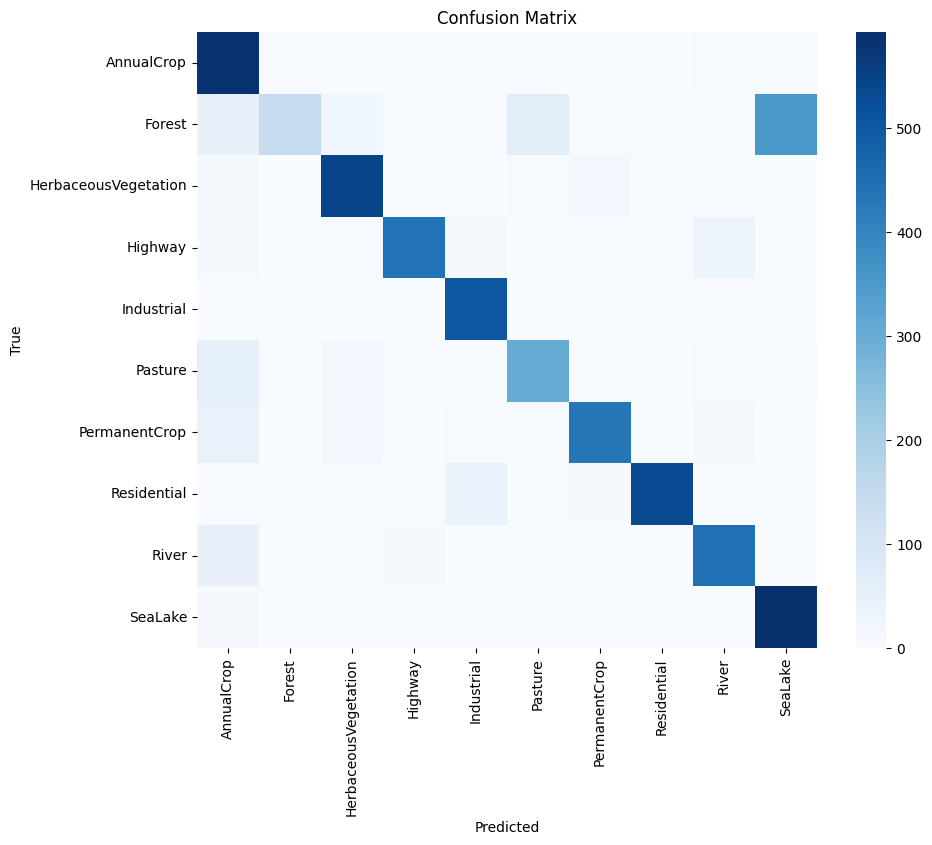

In [7]:
# ================================
# 6. EVALUATION
# ================================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

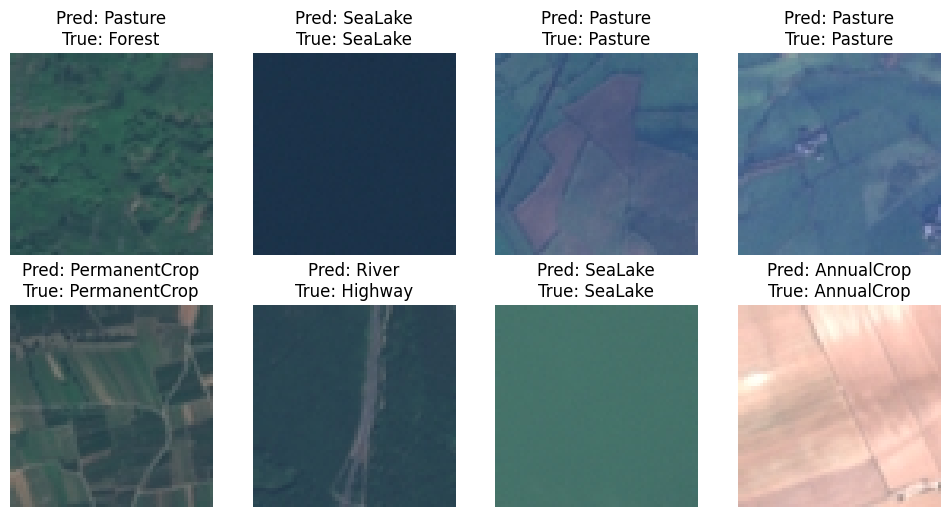

In [8]:
# ================================
# 7. VISUALIZATION OF SAMPLE PREDICTIONS
# ================================
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(title)
    plt.axis("off")

# Show some test predictions
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    imshow(images[i].cpu(), f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}")
plt.show()